In [1]:
# this is jut to view the wide window in jupyter
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from matplotlib.backends.backend_pdf import PdfPages

## Define functions for plotting

In [2]:
def extract_region(df, chromosome, down_region, up_region, function):
    region_df = df[(df['end'] >= down_region) & (df['start'] <= up_region) & 
                   (df['seqname'].str.contains(chromosome))]
    header = region_df[['seqname','end']]
    values = region_df.iloc[:, 3:] # take only columns after "end" column
    values_func = function(values).replace(-np.inf, 0)
    return pd.concat([header, values_func], axis=1)
# consider split the above function in two and put the scaled function as below
def scale_data(df,function):
    header = df[['seqname','end']]
    values = df.iloc[:, 3:] # take only columns after "end" column
    values_func = function(values).replace(-np.inf, 0)
    return pd.concat([header, values_func], axis=1)

def transpose_df(df):    
    df_t = df.set_index(['seqname', 'end']).T
    return df_t

def plot_culstermap_col(df, fig_size=(25,300)):
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    cluster = sns.clustermap(df,
                            cbar=True,
                            vmin=0,
                            col_cluster=False,
                            # row_cluster = False, # avoid cluster rows
                            figsize=fig_size,
                            cbar_pos=(-0.01, .3, .005, .4),
                            dendrogram_ratio=(.1, .3)
#                             dendrogram_ratio=(.0001, .005)
                            )
    plt.setp(cluster.ax_heatmap.xaxis.get_majorticklabels(), rotation=90, fontsize=15)
    plt.setp(cluster.ax_heatmap.yaxis.get_majorticklabels(), fontsize=15)
    return cluster

def drop_columns_rex(df, string):
    droped_df = df.set_index(['seqname', 'start', 'end']).drop(df.filter(regex=string).columns, axis=1)
    return droped_df.reset_index()

def drop_columns_list(df,sample_list):
    droped_df = df.set_index(['seqname', 'start', 'end']).drop(my_list, axis=1)
    return droped_df.reset_index()

def select_genotypes(df, sample_list):
    filter_df = df.set_index(['seqname', 'start', 'end']).filter(items=sample_list, axis=1)
    return filter_df.reset_index()

def chr_length(df, chromosome):
    len_df = pd.read_csv(df, delimiter='\t', header=None)
    return len_df[len_df[0].str.contains(f'{chromosome}')][1].values[0]

In [3]:
data_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/0_IBSpy_data'
chr_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/00_genome_sizes/'

In [4]:
# Define arguments chinese
window = 50000
function = np.sqrt
reference = 'chinese'

In [5]:
synteny_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/04_haplotype_grouping/09_gene_synteny'
data_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/04_haplotype_grouping/0_data'

In [6]:
reference_codes = {\
'ari': 'Arina',
'jag':'Jagger',
'sta':'Stanley',
'jul':'Julius',
'lac':'Lancer',
'ldm':'Landmark',
'mac':'Mace',
'nor':'Norin61',
'sym':'Mattis',
'chi':'CS',
'tsp':'Spelt',
'ash':'Ashsyn'}

In [7]:
def target_genes(pangenome_gene_file, gene, reference_codes):
    synteny_genes = pd.read_csv(pangenome_gene_file, delimiter='\t')
    synteny_genes_ = synteny_genes['chr'].str.split('__', expand=True)[1]
    synteny_genes['ref'] = synteny_genes_.map(reference_codes)
    synteny_genes['chr'] = synteny_genes['chr'].str.split('_', expand=True)[0]
    target_genes_ = synteny_genes[(synteny_genes['srcmodel'].str.contains(gene))]
    return target_genes_

In [8]:
gene_ = 'TraesCS4B02G043100'

matched_gene = target_genes(synteny_path+'/pangenome_gene_synteny.tsv', gene_, reference_codes)
matched_gene

,chr,start,end,ID,srcmodel,ref
59313,chr4B,31493774,31495639,TraesARI4B01G047200,TraesCS4B02G043100.1,Arina
180189,chr4B,32056262,32058127,TraesJAG4B01G045500,TraesCS4B02G043100.1,Jagger
299661,chr4B,30816818,30818683,TraesSTA4B01G044300,TraesCS4B02G043100.1,Stanley
419236,chr4B,30632689,30634554,TraesJUL4B01G046900,TraesCS4B02G043100.1,Julius
537600,chr4B,30638580,30640445,TraesLAC4B01G047100,TraesCS4B02G043100.1,Lancer
658178,chr4B,32253684,32255549,TraesLDM4B01G048800,TraesCS4B02G043100.1,Landmark
776879,chr4B,30805257,30807122,TraesMAC4B01G048000,TraesCS4B02G043100.1,Mace
897308,chr4B,31408404,31410269,TraesNOR4B01G049000,TraesCS4B02G043100.1,Norin61
1015429,chr4B,30449632,30451497,TraesSYM4B01G047400,TraesCS4B02G043100.1,Mattis
1137663,chr4B,30861382,30863247,TraesCHI4B01G048000,TraesCS4B02G043100,CS


In [9]:
def drop_references(df, list_of_ref):
    for ref_i in list_of_ref:
        i = df[(df.ref == ref_i)].index
        df = df.drop(i)
    return df

In [10]:
window = 50000

function = np.sqrt
power_n = 0.43

if function is None:
    function_name = "None"
else:
    function_name = function.__name__

In [11]:
def get_target_region(by_windowd_db, chromosome, down_region, up_region, function=None, power_n=2):
    
    if function is not None:
        function_name = function.__name__
    function_name = "None"
    
    in_db = by_windowd_db
    target_region_df = in_db[\
                             (in_db['end'] >= down_region) & \
                             (in_db['end'] <= up_region) & \
                             (in_db['seqname'].str.contains(chromosome))\
                            ]
    header = target_region_df[['seqname','end']]
    df_values = target_region_df.iloc[:, 2:]
    
    if function_name == 'power':
        power_n = power_n        
        np_values = function(df_values, power_n)
        final_df = pd.concat([header, np_values], axis=1)
    
    elif function is not None:
        np_values = function(df_values).replace(-np.inf, 0)
        final_df = pd.concat([header, np_values], axis=1)
    else:
        final_df = target_region_df
        
    return final_df

In [12]:
data_path = '/Users/quirozc/Documents/PhD_2020/16_watseq/0_IBSpy_data'
# '/Users/quirozc/Documents/PhD_2020/16_watseq/0_IBSpy_data'

In [13]:
def map_substring(s, dict_map):
    for key in dict_map.keys():
        if key in s:
            return dict_map[key]
#         return s

names = {\
        'Jagger':'jagger',
        'Arina':'arinalrfor',
        'Julius':'julius',
        'Lancer':'lancer',
        'Landmark':'landmark',
        'Mace':'mace',
        'Mattis':'sy_mattis',
        'Norin61':'norin61',
        'Spelt':'spelta',
        'Stanley':'stanley',
        'CS':'chinese'
        }

In [14]:
new_col = matched_gene['ref'].apply(lambda x: map_substring(x, names))
matched_gene['ref'] = new_col
matched_gene

,chr,start,end,ID,srcmodel,ref
59313,chr4B,31493774,31495639,TraesARI4B01G047200,TraesCS4B02G043100.1,arinalrfor
180189,chr4B,32056262,32058127,TraesJAG4B01G045500,TraesCS4B02G043100.1,jagger
299661,chr4B,30816818,30818683,TraesSTA4B01G044300,TraesCS4B02G043100.1,stanley
419236,chr4B,30632689,30634554,TraesJUL4B01G046900,TraesCS4B02G043100.1,julius
537600,chr4B,30638580,30640445,TraesLAC4B01G047100,TraesCS4B02G043100.1,lancer
658178,chr4B,32253684,32255549,TraesLDM4B01G048800,TraesCS4B02G043100.1,landmark
776879,chr4B,30805257,30807122,TraesMAC4B01G048000,TraesCS4B02G043100.1,mace
897308,chr4B,31408404,31410269,TraesNOR4B01G049000,TraesCS4B02G043100.1,norin61
1015429,chr4B,30449632,30451497,TraesSYM4B01G047400,TraesCS4B02G043100.1,sy_mattis
1137663,chr4B,30861382,30863247,TraesCHI4B01G048000,TraesCS4B02G043100,chinese


In [15]:
references=[
"chinese",
"arinalrfor",
"jagger",
"julius",
"lancer",
"landmark",
"mace",
"norin61",
# "spelta",
"stanley",
"sy_mattis",
]

In [16]:
my_list = pd.read_csv('rht_D1_genotypes.tsv')['genotype'].tolist()
# my_list

In [17]:
dfs = []
buffer = 500000
for reference in references:
    gene_position = int(matched_gene[matched_gene['ref'] == reference]['start'].values)
    chromosome = matched_gene[matched_gene['ref'] == reference]['chr'].values[0]
    down_region = gene_position - buffer
    up_region = gene_position + buffer

    file_db = pd.read_csv(f'{data_path}/{reference}_combined_queries_{window}w.tsv.gz', delimiter='\t', usecols=my_list)

    get_target_region_ = get_target_region(file_db, chromosome, down_region, up_region, function, power_n)
    dfs.append(get_target_region_)
dfs_concat = pd.concat(dfs, axis=0)
dfs_concat

,seqname,end,arina-pg,chinese-pg,jagger-pg,julius-pg,lancer-pg,landmark-pg,mace-pg,mattis-pg,...,Revelation,Altria,Recital,Galahad,Flame,KWS_Santiago,Camp_Remy,wasp,Gabo,festival
139716,chr4B,30400000,4.242641,0.000000,4.123106,4.582576,3.872983,5.656854,5.291503,4.123106,...,19.544820,3.605551,4.358899,19.131126,19.544820,4.690416,19.595918,19.493589,5.477226,19.313208
139717,chr4B,30450000,4.795832,0.000000,5.196152,5.099020,4.795832,4.898979,4.472136,4.690416,...,22.113344,4.242641,5.000000,22.045408,22.135944,5.656854,22.383029,22.338308,5.000000,22.158520
139718,chr4B,30500000,4.898979,0.000000,4.242641,4.472136,4.123106,4.358899,4.898979,4.582576,...,23.579652,4.582576,4.690416,23.494680,23.452079,5.477226,23.643181,23.430749,5.196152,23.452079
139719,chr4B,30550000,4.472136,0.000000,5.656854,5.099020,5.000000,7.000000,5.291503,4.795832,...,21.817424,4.472136,5.830952,22.181073,21.908902,5.477226,21.977261,21.863211,4.795832,22.248595
139720,chr4B,30600000,7.280110,0.000000,4.358899,3.464102,4.358899,4.472136,3.741657,4.123106,...,18.055470,4.358899,4.472136,17.748239,17.663522,4.690416,17.748239,17.972201,4.123106,17.635192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139746,chr4B_WhSYM,30700000,4.472136,5.567764,0.000000,4.582576,0.000000,0.000000,5.477226,0.000000,...,5.099020,0.000000,2.000000,18.220867,5.000000,2.645751,18.520259,18.574176,18.547237,18.574176
139747,chr4B_WhSYM,30750000,3.872983,3.464102,2.000000,4.358899,0.000000,0.000000,3.000000,0.000000,...,5.385165,0.000000,3.316625,18.110770,5.000000,2.645751,18.083141,18.110770,18.248288,18.330303
139748,chr4B_WhSYM,30800000,3.162278,3.316625,0.000000,3.605551,0.000000,1.732051,3.872983,0.000000,...,4.000000,1.414214,2.000000,21.656408,3.464102,3.316625,21.260292,21.330729,21.517435,21.330729
139749,chr4B_WhSYM,30850000,4.242641,4.795832,3.464102,3.464102,1.000000,4.358899,3.000000,0.000000,...,3.316625,1.000000,2.645751,16.031220,4.582576,3.605551,16.673332,16.340135,16.340135,16.462078


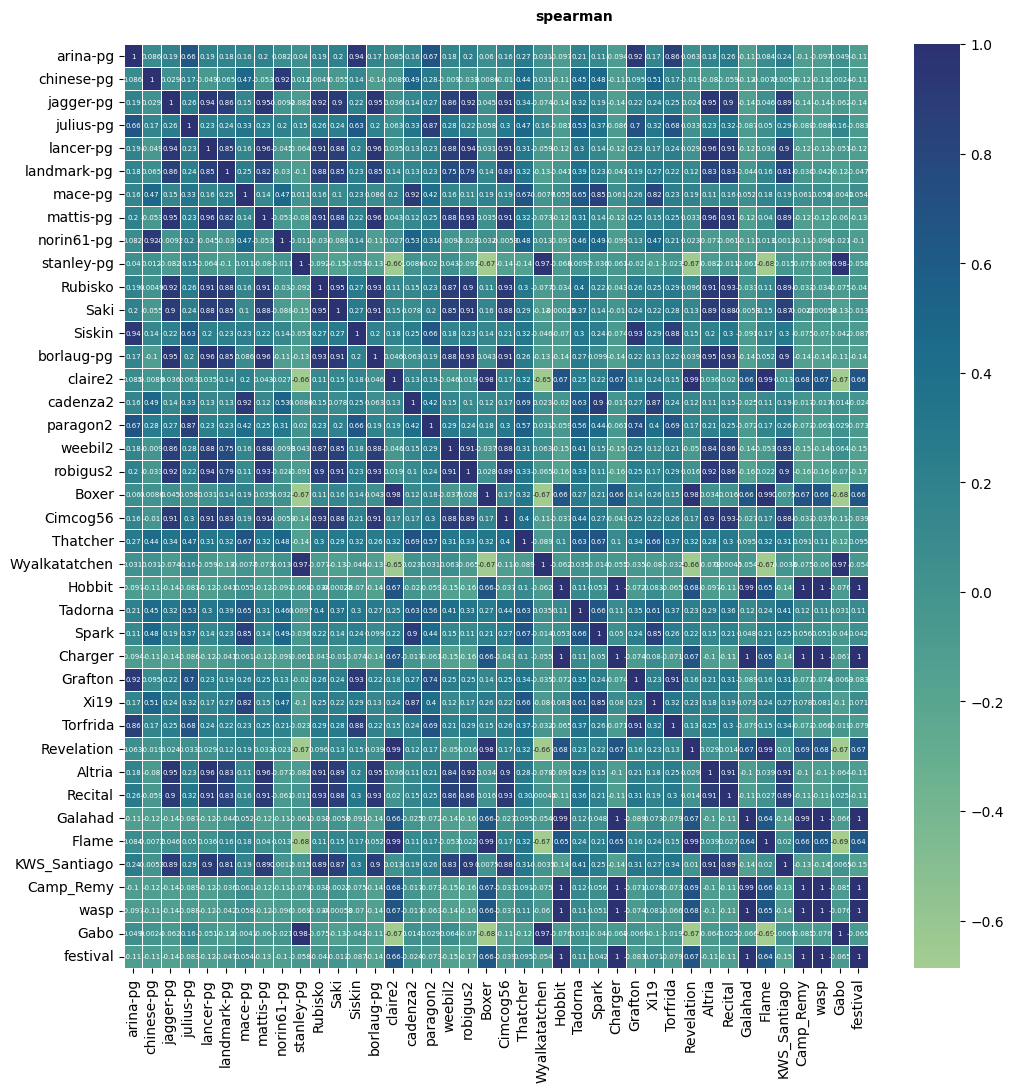

In [18]:
# m_correlation = ['pearson', 'kendall', 'spearman']
m_correlation = ['spearman']

for corr in m_correlation:

    correlation_df = dfs_concat.iloc[:, 2:].corr(method = corr)
    plt.figure(figsize=(12, 12)).suptitle(f'{corr}', fontsize=10, va="baseline", weight="bold", y=0.9)
    sns.heatmap(correlation_df, annot=True, annot_kws={"size": 5},linewidth=.5, cmap="crest")

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


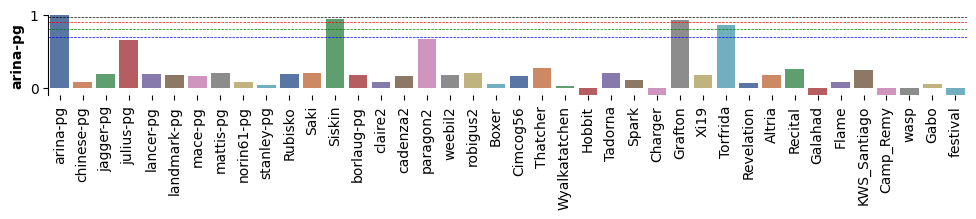

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


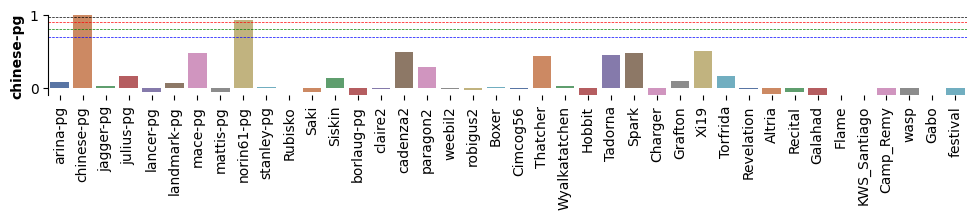

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


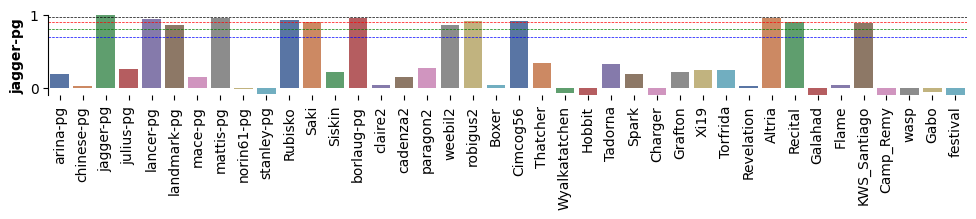

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


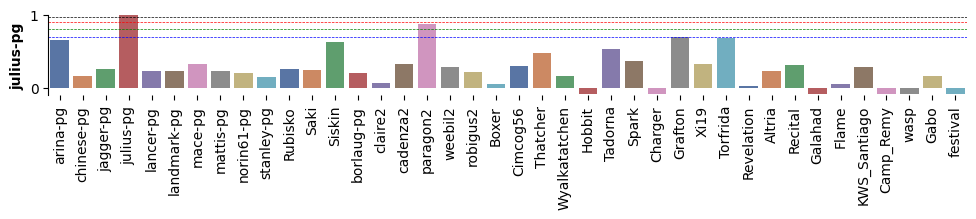

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


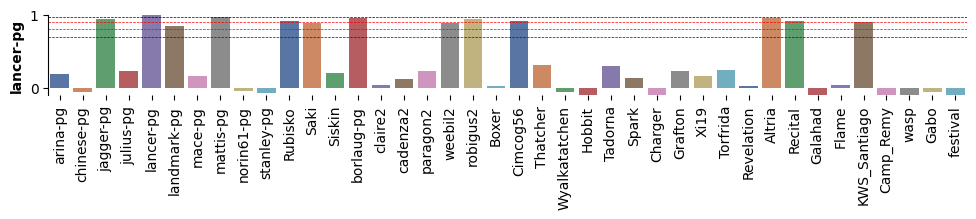

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


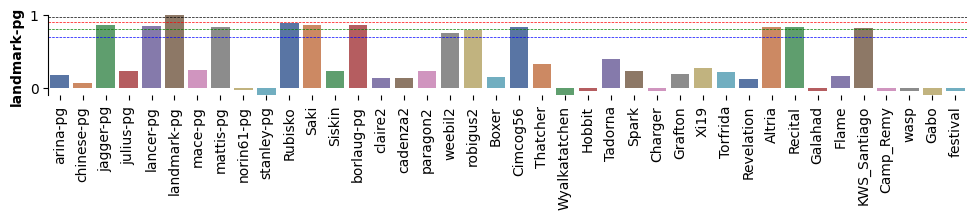

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


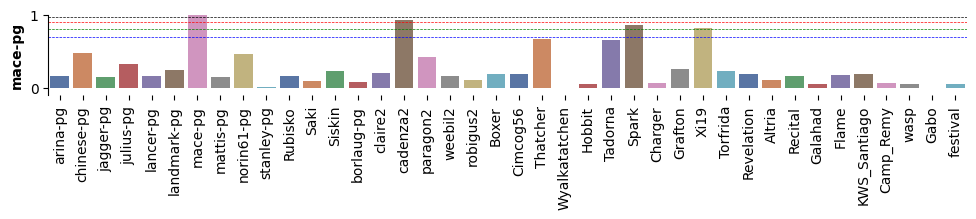

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


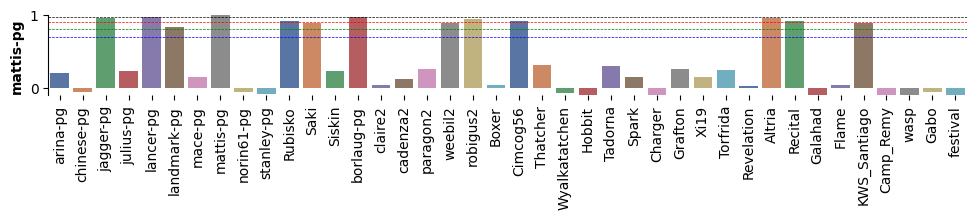

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


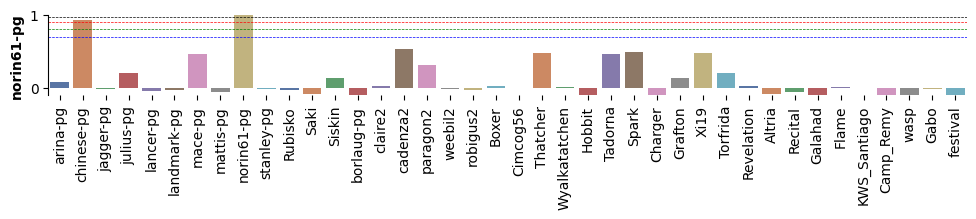

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


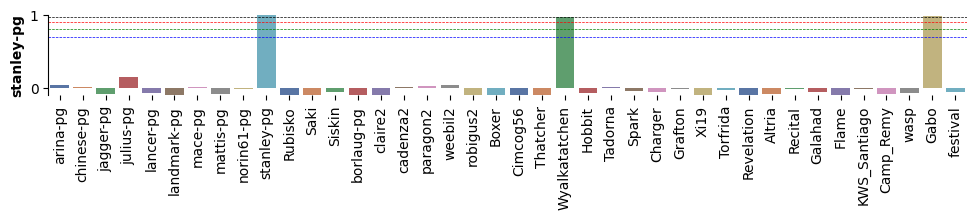

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


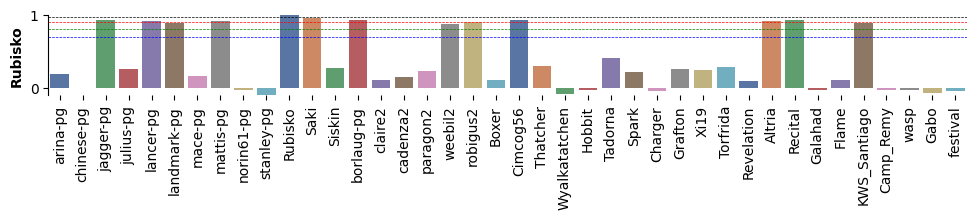

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


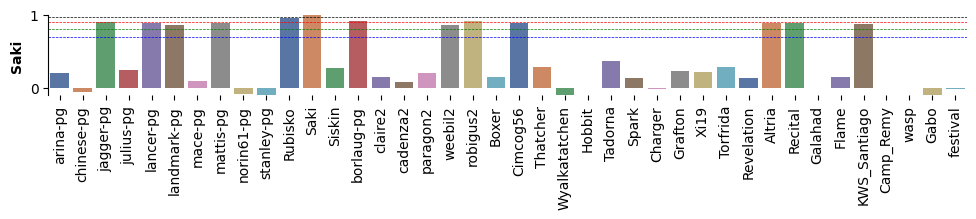

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


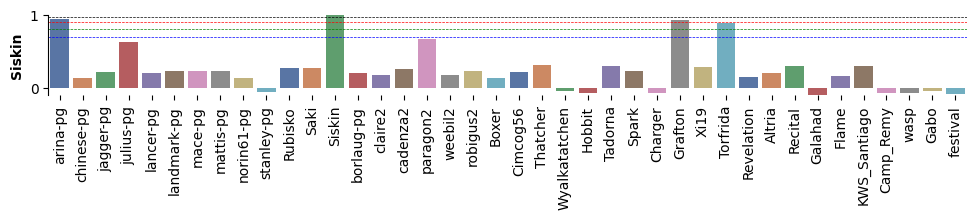

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


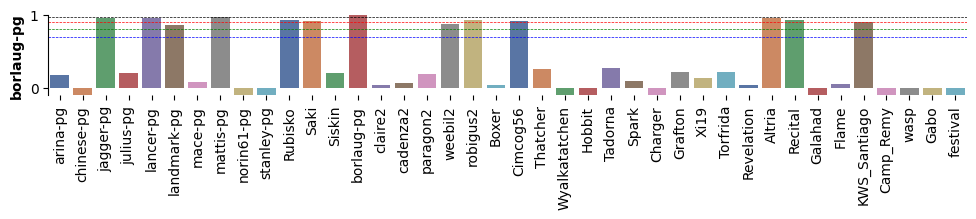

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


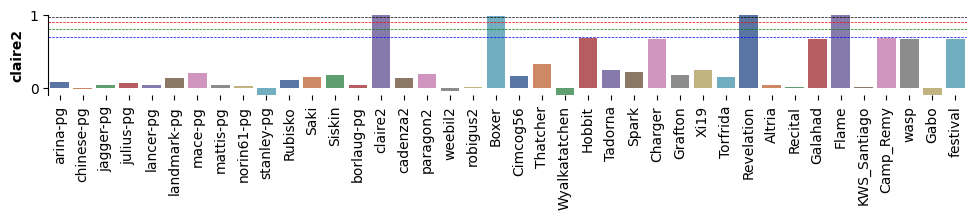

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


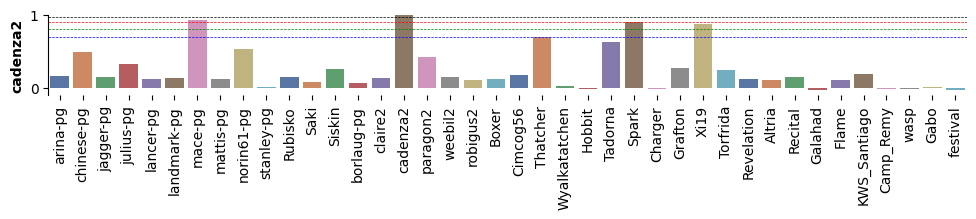

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


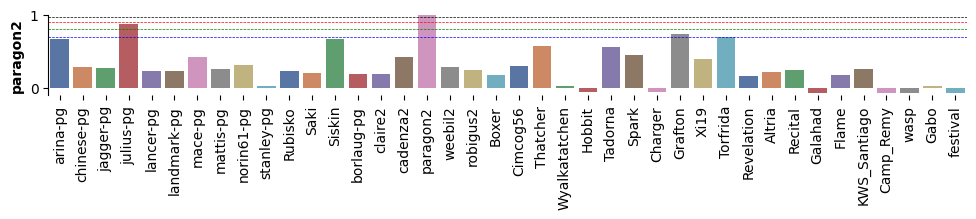

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


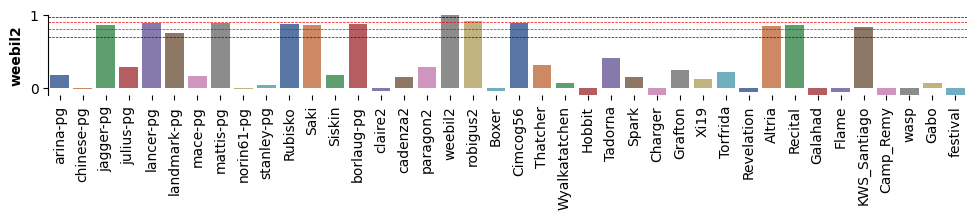

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


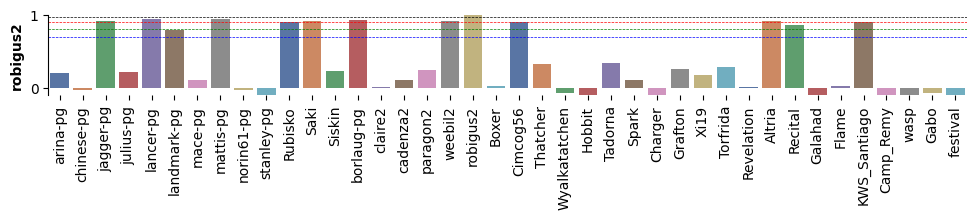

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


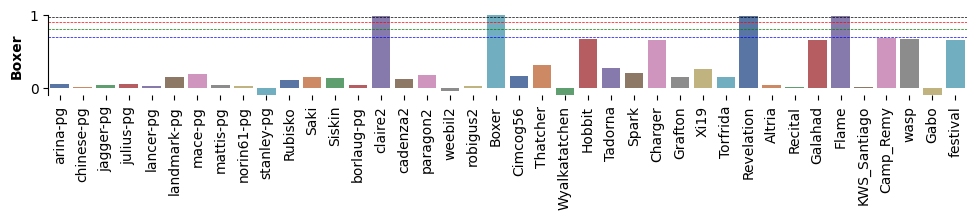

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


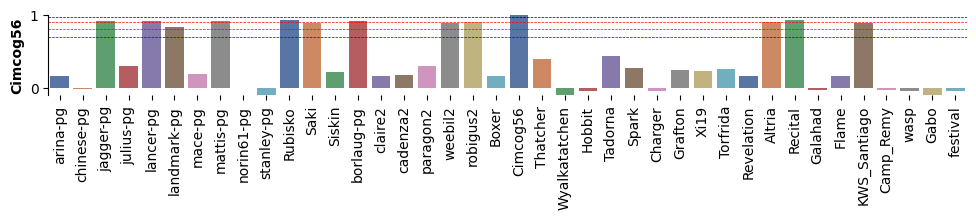

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


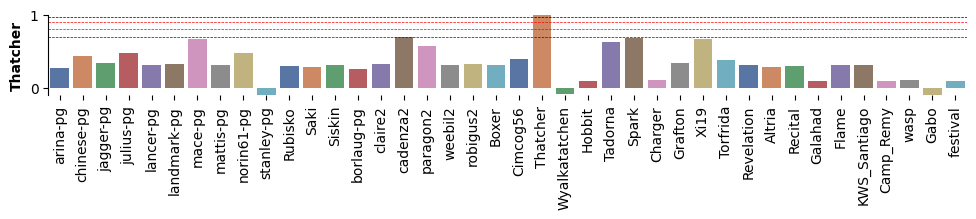

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


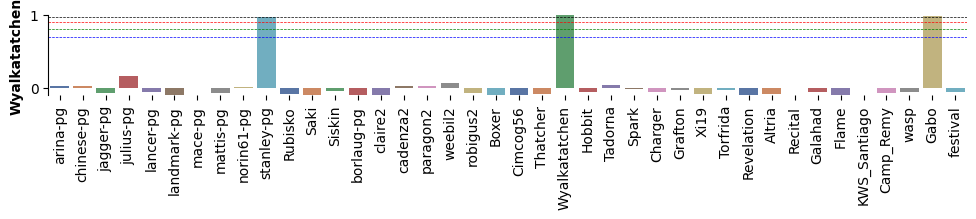

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


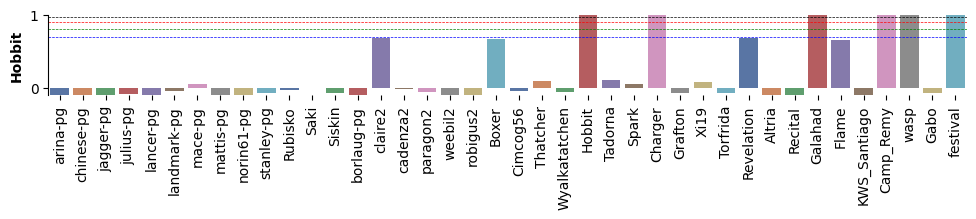

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


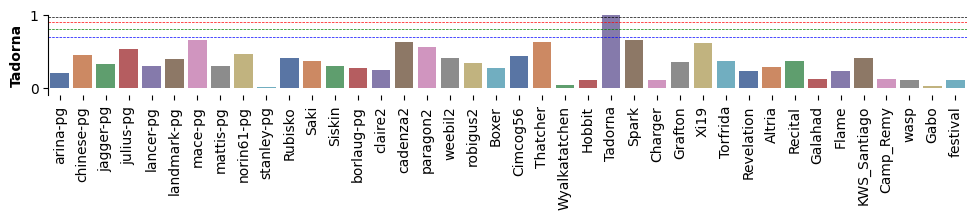

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


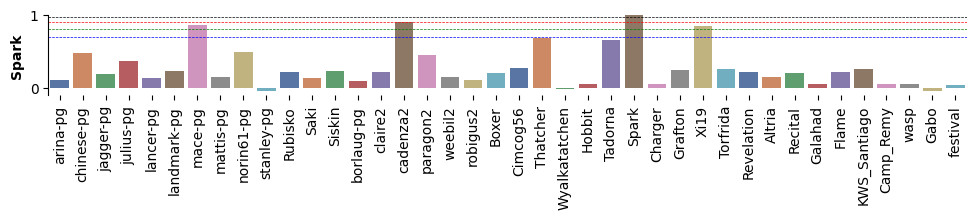

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


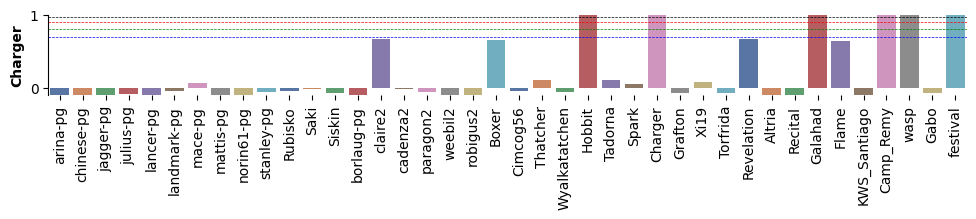

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


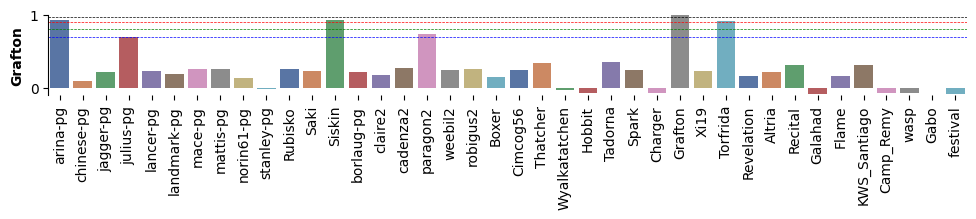

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


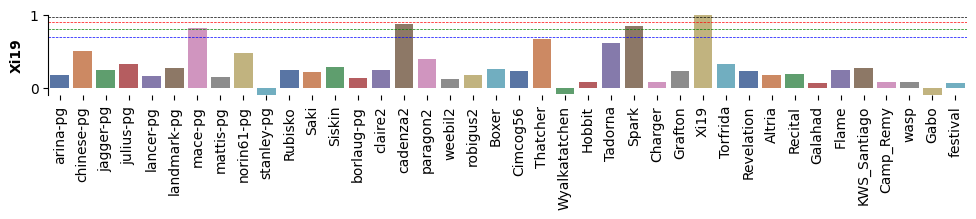

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


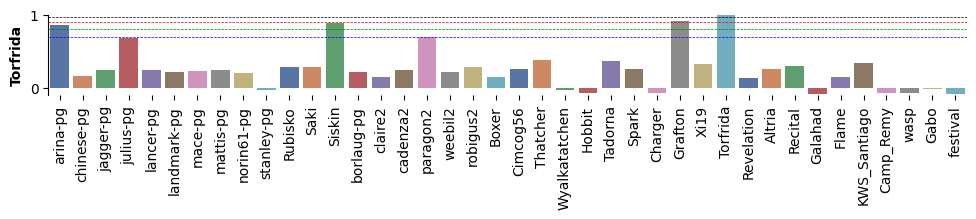

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


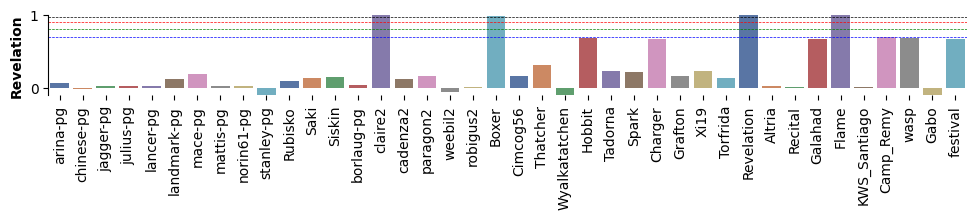

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


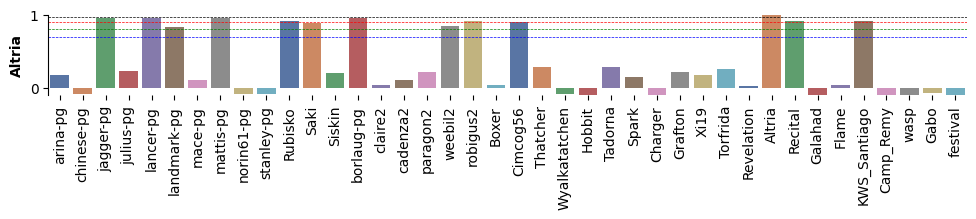

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


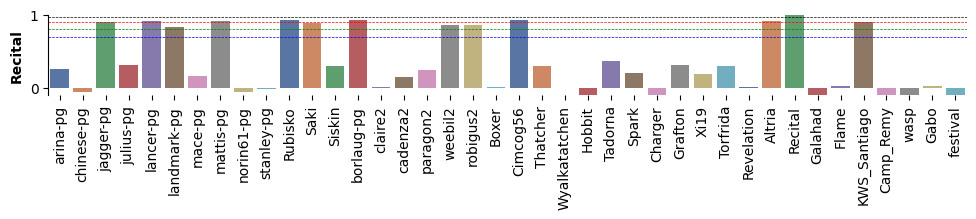

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


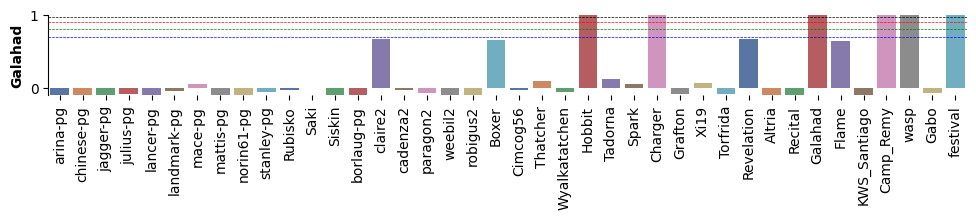

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


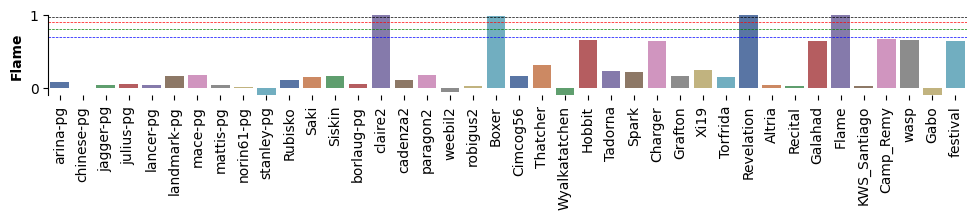

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


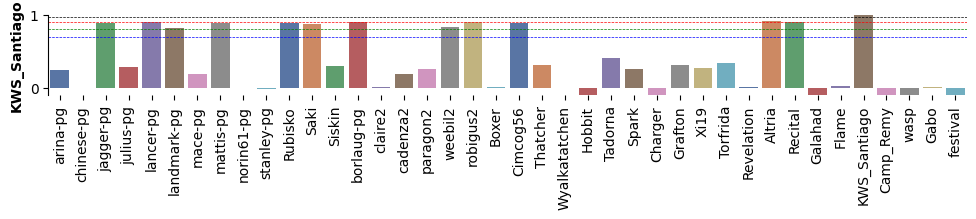

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


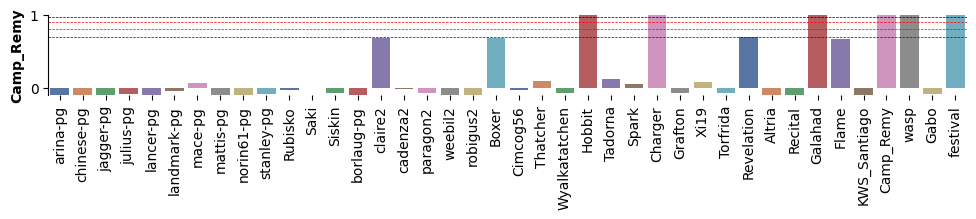

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


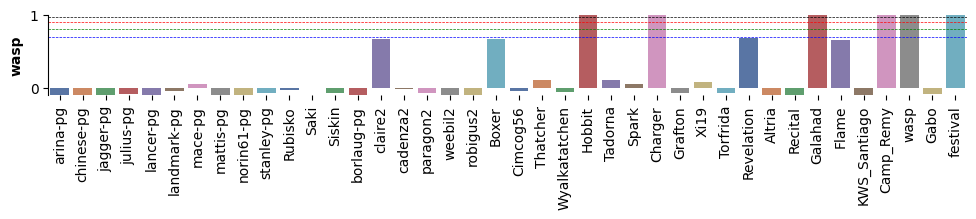

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


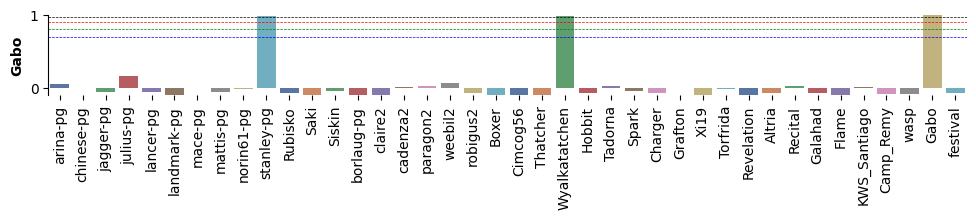

/var/folders/x6/wm6w59m54v5518frzs6xldbr000cws/T/ipykernel_1759/2028128000.py:19: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.set_ylim(-0.1, 1, 0.25)


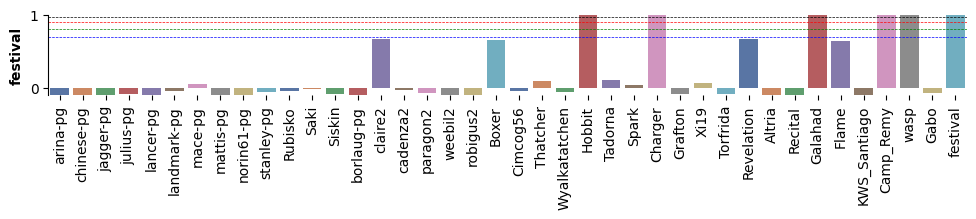

In [19]:
# m_correlations = ['pearson', 'kendall', 'spearman']
m_correlations = ['spearman']

for correlation_ in m_correlations:
    
    df = dfs_concat.iloc[:, 2:].corr(method = correlation_)

    with PdfPages(f'correlation_{gene_}_{correlation_}_{buffer}_multiple_ref.pdf') as pdf:
        for index, row in df.iterrows():
            name = index
            row = row
            x = np.array(row.index)
            y = row.values

            f, (ax) = plt.subplots(1, 1, figsize=(10, 2.3), sharex=True)
#             f.suptitle(f'{correlation_}_{chromosome}', fontweight="bold", fontsize=12)

            ax.set_ylabel(name, fontsize=10)
            ax.set_ylim(-0.1, 1, 0.25)
            ax.axhline(y=0.96, linewidth=0.5, color='k', linestyle="--")
            ax.axhline(y=0.90, linewidth=0.5, color='r', linestyle="--")
            ax.axhline(y=0.80, linewidth=0.5, color='g', linestyle="--")
            ax.axhline(y=0.70, linewidth=0.5, color='b', linestyle="--")
            ax.set_ylabel(name, fontweight = "bold", fontsize = 10)


            sns.barplot(x=x, y=y, palette="deep", ax=ax)

            plt.xticks(rotation=90, fontsize=10)
            sns.despine(bottom=True)
            plt.tight_layout(h_pad=2)
            pdf.savefig(dpi = 75, transparent = True, bbox_inches='tight')
            plt.show()    
            plt.close()